In [1]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *


c:\Users\nntin\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
c:\Users\nntin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

c:\Users\nntin\uni\fyp\fyp2023


In [3]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

Sequence 3 of 3
Generated 9 signals and 9 labels in 0.031000000017229468


In [4]:
len(signals)

9

Letters: [89, 56, 165, 40, 132, 143, 174] 
barcodes: [1, 2] 
ctc_labels: [256, 89, 256, 56, 256, 165, 256, 40, 256, 132, 256, 143, 256, 174, 256]


9

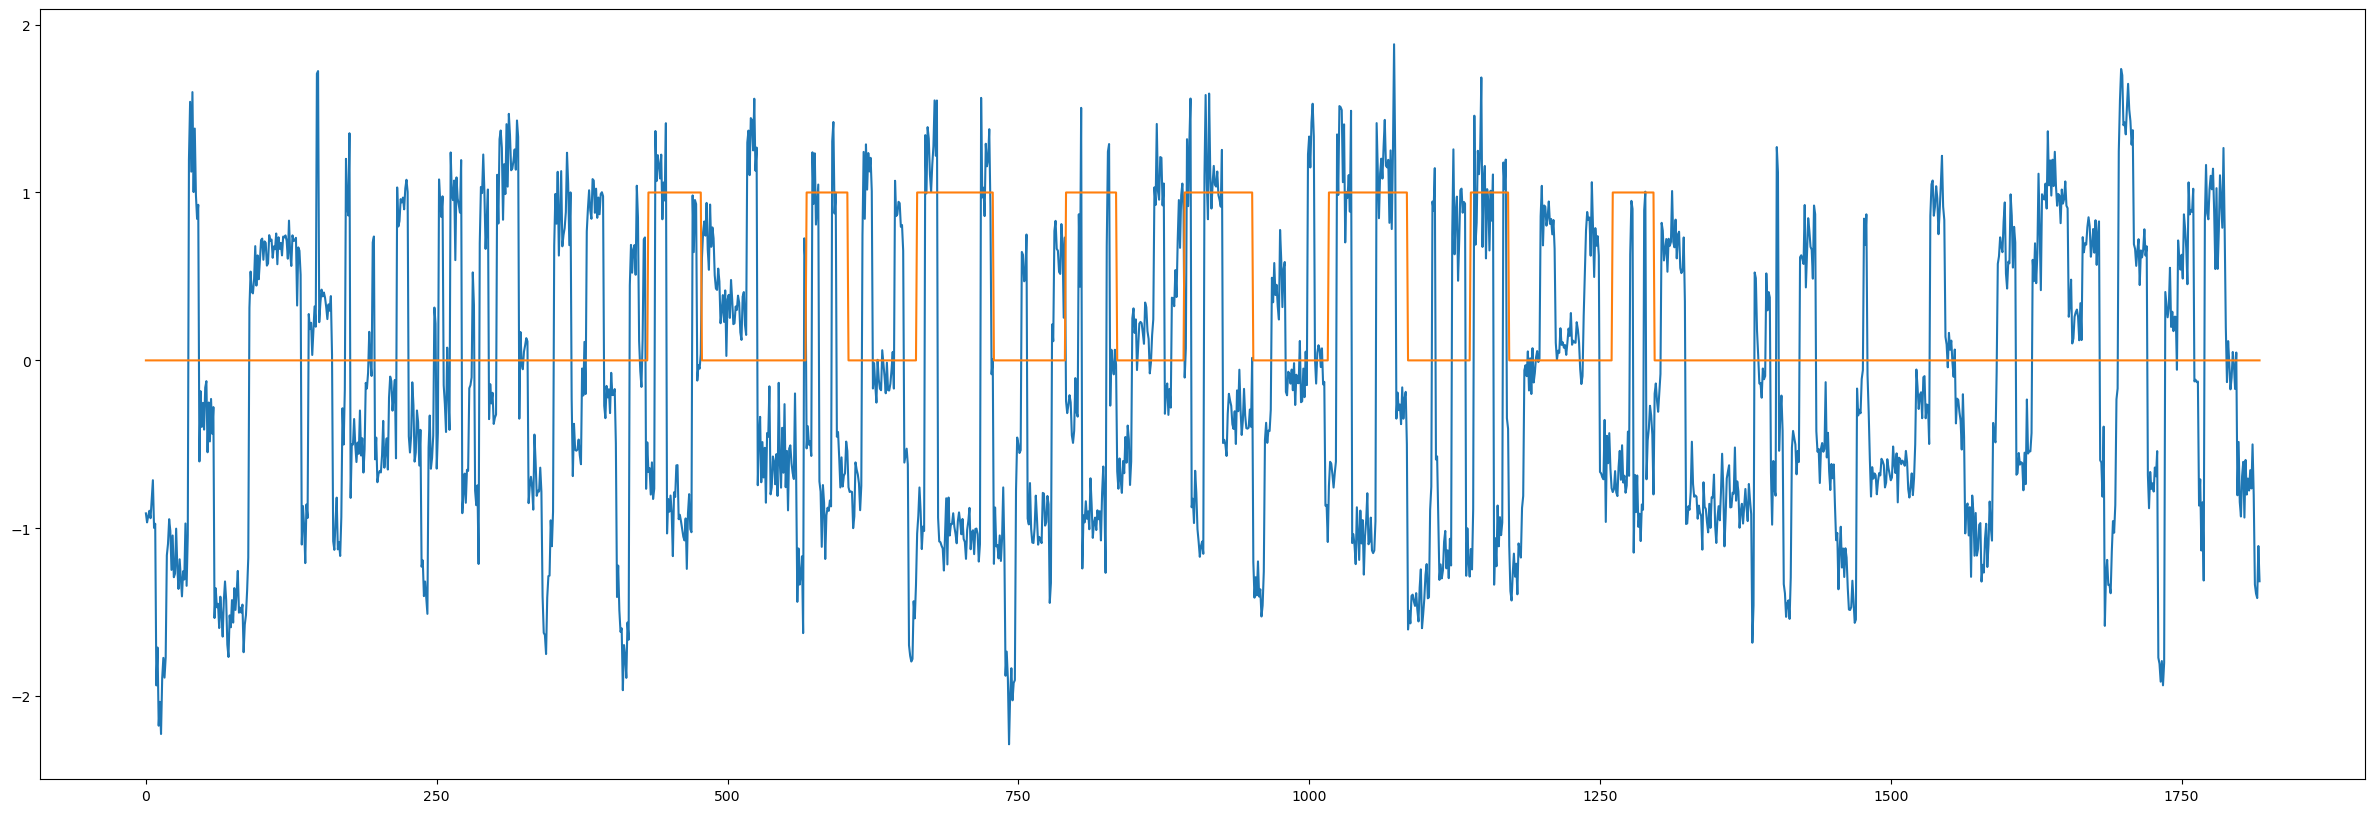

In [5]:
plt.figure(figsize=(30, 10))
i  = 1
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

len(signals)

In [6]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [7]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'quartznet_ljspeech', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 258, 'feat_in': 1}}

In [8]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    TextPreprocess(),# removing punctuation in text - might not needed
    ToNumpy(), # convert audio to numpy
    BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    AddGaussianNoise(
        min_amplitude=0.001,
        max_amplitude=0.015,
        p=0.5
    ),
    TimeStretch(
        min_rate=0.8,
        max_rate=1.25,
        p=0.5
    ),
    PitchShift(
        min_semitones=-4,
        max_semitones=4,
        p=0.5
    )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get('sample_rate', 16000),
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    MaskSpectrogram(
        probability=0.5,
        time_mask_max_percentage=0.05,
        frequency_mask_max_percentage=0.15
    ),
    AddLengths(),
    Pad()
])

transforms_val = Compose([
    TextPreprocess(),
    ToNumpy(),
    BPEtexts(bpe=bpe),
    AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
train_dataset = dataset_module.get_dataset(
    config, transforms=transforms_train, part='train')
val_dataset = dataset_module.get_dataset(
    config, transforms=transforms_val, part='val')
# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)

# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

[{'filters': 256, 'repeat': 1, 'kernel': 33, 'stride': 2, 'dilation': 1, 'dropout': 0.2, 'residual': False, 'separable': True}, {'filters': 256, 'repeat': 5, 'kernel': 33, 'stride': 1, 'dilation': 1, 'dropout': 0.2, 'residual': True, 'separable': True}, {'filters': 256, 'repeat': 5, 'kernel': 39, 'stride': 1, 'dilation': 1, 'dropout': 0.2, 'residual': True, 'separable': True}, {'filters': 512, 'repeat': 5, 'kernel': 51, 'stride': 1, 'dilation': 1, 'dropout': 0.2, 'residual': True, 'separable': True}, {'filters': 512, 'repeat': 5, 'kernel': 63, 'stride': 1, 'dilation': 1, 'dropout': 0.2, 'residual': True, 'separable': True}, {'filters': 512, 'repeat': 5, 'kernel': 75, 'stride': 1, 'dilation': 1, 'dropout': 0.2, 'residual': True, 'separable': True}, {'filters': 512, 'repeat': 1, 'kernel': 87, 'stride': 1, 'dilation': 2, 'dropout': 0.2, 'residual': False, 'separable': True}, {'filters': 1024, 'repeat': 1, 'kernel': 1, 'stride': 1, 'dilation': 1, 'dropout': 0.2, 'residual': False, 'separab

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nguyennhuttin (monash-deep-neuron). Use `wandb login --relogin` to force relogin


[]

In [9]:
print(bpe.vocab())
bpe.vocab().index('▁')
int_to_char = bpe.id_to_subword
int_to_char(3)

['<PAD>', '<UNK>', '<BOS>', '<EOS>', '▁', 'e', 't', 'a', 'o', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'c', 'f', 'u', 'm', 'w', 'p', 'g', 'y', 'b', 'v', 'k', 'x', 'q', 'j', 'z', 'ü', '”', '“', 'é', '’', 'ê', 'è', 'â', 'à', '▁t', 'he', '▁a', '▁the', 'in', '▁o', '▁w', 're', '▁s', 'en', 'on', 'er', 'ed', '▁c', 'at', '▁b', '▁p', '▁f', '▁of', 'nd', '▁h', 'is', 'it', '▁m', 'or', '▁in', 'as', '▁to', 'al', 'ar', 'ou', 'es', '▁and', '▁d', '▁th', 'ing', 'an', '▁n', 'ic', 'ent', 'ion', '▁l', 'ro', '▁e', '▁was', '▁he', 'ot', '▁re', 'ly', 'le', '▁be', 'ad', 'id', '▁on', 'im', 've', 'st', 'om', 'll', '▁wh', '▁that', '▁g', 'ct', 'se', 'ut', 'et', '▁for', 'gh', 'ce', '▁as', '▁u', '▁st', 'ir', 'ld', 'ere', '▁his', 'ri', 'ur', 'qu', '▁at', 'ow', 'ver', '▁con', 'ith', '▁it', 'ation', '▁with', '▁had', '▁an', 'ght', 'ers', 'if', 'res', '▁se', 'am', 'her', '▁by', '▁were', '▁ne', 'ay', 'ain', 'il', 'ch', 'ter', 'ich', '▁qu', '▁de', 'ate', '▁which', '▁ex', '▁not', '▁com', 'ol', '▁ha', 'sw', 'ra', '▁or', '▁su', 'est

'<EOS>'

In [12]:

for epoch_idx in tqdm(range(config.train.get('epochs', 10))):
    # train:
    model.train()
    for batch_idx, batch in enumerate(train_dataloader):
        batch1=batch
        # print(len(batch1['audio'][0]))
        batch = batch_transforms_train(batch)
        batch2=batch
        # print(len(batch2['audio'][0]))

        optimizer.zero_grad()
        print('batch audio shape:', batch['audio'].shape)
        logits = model(batch['audio'])
        print('logits shape:', logits.shape)
        
        output_length = torch.ceil(
            batch['input_lengths'].float() / model.stride).int()
        print('output_length shape:',output_length)
        print('target_lengths:',batch['target_lengths'])
        
        loss = criterion(logits.permute(2, 0, 1).log_softmax(
            dim=2), batch['text'], output_length, batch['target_lengths']) # target_length is the length of text of batch1 (before batch aug)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), config.train.get('clip_grad_norm', 15))
        optimizer.step()
        lr_scheduler.step()
        # warmup_scheduler.dampen()
        if batch_idx % config.wandb.get('log_interval', 5000) == 0:
            target_strings = decoder.convert_to_strings(batch['text'])
            decoded_output = decoder.decode(
                logits.permute(0, 2, 1).softmax(dim=2))
            wer = np.mean([decoder.wer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            cer = np.mean([decoder.cer(true, pred)
                            for true, pred in zip(target_strings, decoded_output)])
            step = epoch_idx * \
                len(train_dataloader) * train_dataloader.batch_size + \
                batch_idx * train_dataloader.batch_size
            wandb.log({
                "train_loss": loss.item(),
                "train_wer": wer,
                "train_cer": cer,
                "train_samples": wandb.Table(
                    columns=['gt_text', 'pred_text'],
                    data=list(zip(target_strings, decoded_output))
                )
            }, step=step)
        break
    # #!
    # # validate:
    # model.eval()
    # val_stats = defaultdict(list)
    # for batch_idx, batch in enumerate(val_dataloader):
    #     batch = batch_transforms_val(batch)
    #     with torch.no_grad():
    #         logits = model(batch['audio'])
    #         output_length = torch.ceil(
    #             batch['input_lengths'].float() / model.stride).int()
    #         loss = criterion(logits.permute(2, 0, 1).log_softmax(
    #             dim=2), batch['text'], output_length, batch['target_lengths'])

    #     target_strings = decoder.convert_to_strings(batch['text'])
    #     decoded_output = decoder.decode(
    #         logits.permute(0, 2, 1).softmax(dim=2))
    #     wer = np.mean([decoder.wer(true, pred)
    #                     for true, pred in zip(target_strings, decoded_output)])
    #     cer = np.mean([decoder.cer(true, pred)
    #                     for true, pred in zip(target_strings, decoded_output)])
    #     val_stats['val_loss'].append(loss.item())
    #     val_stats['wer'].append(wer)
    #     val_stats['cer'].append(cer)
    # for k, v in val_stats.items():
    #     val_stats[k] = np.mean(v)
    # val_stats['val_samples'] = wandb.Table(
    #     columns=['gt_text', 'pred_text'], data=zip(target_strings, decoded_output))
    # wandb.log(val_stats, step=step)

    # # save model, TODO: save optimizer:
    # if val_stats['wer'] < prev_wer:
    #     os.makedirs(config.train.get(
    #         'checkpoint_path', 'checkpoints'), exist_ok=True)
    #     prev_wer = val_stats['wer']
    #     torch.save(
    #         model.state_dict(),
    #         os.path.join(config.train.get(
    #             'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth')
    #     )
    #     wandb.save(os.path.join(config.train.get(
    #         'checkpoint_path', 'checkpoints'), f'model_{epoch_idx}_{prev_wer}.pth'))
    break

  0%|          | 0/42 [00:00<?, ?it/s]

batch audio shape: torch.Size([8, 1, 1066])
logits shape: torch.Size([8, 258, 533])
output_length shape: tensor([533, 105, 533, 284, 448, 314, 463,  99], device='cuda:0',
       dtype=torch.int32)
target_lengths: tensor([61, 13, 76, 43, 63, 34, 55, 10], device='cuda:0')


  0%|          | 0/42 [00:02<?, ?it/s]


In [11]:
target_strings, decoded_output

(['▁printing▁in▁the▁only▁sense▁with▁which▁we▁are▁at▁present▁concerned▁differs▁from▁most▁if▁not▁from▁all▁the▁arts▁and▁crafts▁represented▁in▁the▁exhibition',
  '▁in▁being▁comparatively▁modern',
  '▁for▁although▁the▁chinese▁took▁impressions▁from▁wood▁blocks▁engraved▁in▁relief▁for▁centuries▁before▁the▁woodcutters▁of▁the▁netherlands▁by▁a▁similar▁process',
  '▁produced▁the▁block▁books▁which▁were▁the▁immediate▁predecessors▁of▁the▁true▁printed▁book',
  '▁the▁invention▁of▁movable▁metal▁letters▁in▁the▁middle▁of▁the▁fifteenth▁century▁may▁justly▁be▁considered▁as▁the▁invention▁of▁the▁art▁of▁printing',
  '▁and▁it▁is▁worth▁mention▁in▁passing▁that▁as▁an▁example▁of▁fine▁typography',
  '▁the▁earliest▁book▁printed▁with▁movable▁types▁the▁gutenberg▁or▁fortytwo▁line▁bible▁of▁about▁fourteen▁fiftyfive',
  '▁has▁never▁been▁surpassed'],
 ['enersatedvroü▁m▁wheatg▁fromor▁vatedbifr▁comtghtentordgresilresident▁meen▁t▁gt▁ch▁they▁com▁osw▁been▁g▁pres▁gers▁v▁been▁mées▁mredabdilr▁ch▁fraü▁ordatswomers▁mge▁isüreseredixabe

In [ ]:
batch2.keys()

dict_keys(['audio', 'text', 'sample_rate', 'input_lengths', 'target_lengths'])

In [ ]:
batch2['input_lengths']

tensor([1065,  210, 1066,  567,  895,  627,  925,  197], device='cuda:0')

In [ ]:
print(len(batch1['audio'])) # batchsize
print(len(batch1['audio'][0]))
print(len(batch2['audio'][0]))
print(max([len(x) for x in batch1['audio'] ]))

8
212893
64
213149


In [ ]:
a=train_dataset.dataset.__getitem__(0)
print(a)
# len(train_dataset.dataset.__getitem__(0)['text'])
print(a['text'].shape)

{'audio': array([-0.00593663,  0.00386262, -0.00696853, ..., -0.00012403,
        0.00103233,  0.00324413], dtype=float32), 'text': array([ 56,  12,  44,   6,  75,  65,  43,  93,  88,  48,  49, 103,  46,
        62,  13,  99,  78,  13,  46,   5,  42,  47, 119,  56,  47,  11,
        79,  53,  50,  16,  51,   9,  52,  73,  10,  17,  17,  51,  11,
        57,  82,  19,  63,   8,  96,   4,  10,  17,  77,  86,  57,  82,
        19,  42,  98,  43,  42,  12,   6,  11,  42,   9,  14,  53,  12,
         7,  17,   6,  11,  87,  21,  47,  11,  79,  52,  65,  74,   5,
        83,  27,  13,  10,  24,  62,  80]), 'sample_rate': 22050}
(85,)


In [ ]:
# load datasets
train_dataset_2 = dataset_module.get_dataset(
    config, part='train')
b = train_dataset_2.dataset.__getitem__(0)
# len(train_dataset_2.dataset.__getitem__(0)['text'])
print(b)
import string
translator = str.maketrans('', '', string.punctuation)
print(len(b['text'].translate(translator)))

{'audio': tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
          2.1362e-04,  6.1035e-05]]), 'text': 'Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', 'sample_rate': 22050}
149


In [ ]:
print(len(batch1['audio'][0]))
print(len(batch2['audio'][0]))
print(len(batch1['text'][2]))
print(len(batch2['text'][1]))


212893
64
95
95


In [ ]:
len(batch1)
len(batch1['audio'])

8

In [ ]:
print(batch2['audio'].shape)
print(batch2['text'].shape)
print(batch2['text'][3])
print(batch2['audio'][3].dtype)

torch.Size([8, 64, 1066])
torch.Size([8, 95])
tensor([ 56,  82,  14,  18,  16,  52,  43,  55,  15,   8,  16,  26,  55,   8,
          8,  26,  11,  99,  78,  13,  46, 114,  43,   4,  94,  19,  52,  10,
         54,   5,  56,  47,  14,   5,  16,  71,  11,  64,  11,  58,  43,  40,
         12,  18,   5,  56,  12,  44,   6,  52,  55,   8,   8,  26,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       device='cuda:0', dtype=torch.int32)
torch.float32
